# Initialization

## Imports


In [22]:
# add src to path
from pyprojroot import here
import sys

sys.path.append(str(here("src")))

# import analysis_utils
from code.models import *
from code.analysis_utils import *

# load other libraries
from dotenv import load_dotenv
import logging
from pandas.errors import SettingWithCopyWarning

load_dotenv()

from code.make_figs import FigureGenerator
from code.analysis_pipeline import AnalysisPipeline

# suppress logging and warnings
import warnings

logging.getLogger("code.utils").setLevel(
    logging.WARNING
)  # suppress logging of dataset sizes from train_utils
logging.getLogger("code.models").setLevel(
    logging.WARNING
)  # suppress logging of model parameters from models.py
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# configure numpy and pytorch to print entire arrays/tensors
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=torch.inf)

## Set up analysis pipeline


In [17]:
# choose variables to evaluate
CONTEXT_LENGTH_TO_EVAL = [128]
MLP_EXPANSION_FACTOR_TO_EVAL = [4]
NUM_DIMS_TO_EVAL = [8]
NUM_TASKS_TO_EVAL = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
SAVE_FIGS = False
SETTING = "categorical-sequence"
EXP_NAME = "full-exp-params"

fixed_values = {
    "context_length": CONTEXT_LENGTH_TO_EVAL[0],
    "mlp_expansion_factor": MLP_EXPANSION_FACTOR_TO_EVAL[0],
    "num_dims": NUM_DIMS_TO_EVAL[0],
}

analysis_pipeline = AnalysisPipeline(
    setting=SETTING,
    exp_name=EXP_NAME,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    mlp_expansion_factor_to_eval=MLP_EXPANSION_FACTOR_TO_EVAL,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
)

experiment params:  {'setting': 'categorical-sequence', 'num_dims_lst': [8, 12, 16], 'num_tasks_lst': [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], 'context_length_lst': [128, 256, 320], 'mlp_expansion_factor_lst': [0.5, 4, 8], 'random_seed': 1, 'num_hidden_layers': 1, 'hidden_size': 64, 'batch_size': 64, 'learning_rate': 0.0005, 'max_steps': 100000, 'save_steps': [20, 58, 115, 193, 291, 408, 545, 703, 879, 1076, 1293, 1529, 1785, 2062, 2357, 2673, 3009, 3364, 3739, 4135, 4549, 4984, 5439, 5913, 6407, 6921, 7455, 8009, 8583, 9176, 9789, 10422, 11075, 11748, 12441, 13153, 13885, 14637, 15409, 16201, 17013, 17844, 18695, 19566, 20457, 21368, 22298, 23249, 24219, 25209, 26219, 27249, 28298, 29368, 30457, 31566, 32695, 33844, 35012, 36201, 37409, 38637, 39885, 41153, 42440, 43747, 45075, 46422, 47789, 49175, 50582, 52008, 53455, 54921, 56407, 57912, 59438, 60983, 62548, 64133, 65738, 67363, 69008, 70672, 72356, 74060, 75784, 77528, 79291, 81075, 82878, 84701, 86544, 88407, 90289, 92

  0%|          | 0/29700 [00:00<?, ?it/s]

## Process data

In [18]:
algo_df = analysis_pipeline.process_algo_df(
    analysis_pipeline.algo_df_raw,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    num_tasks_to_eval=NUM_TASKS_TO_EVAL,
    load_saved_evaluation=True,
)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [19]:
transformer_df_all_checkpoints = analysis_pipeline.process_transformer_df(
    analysis_pipeline.transformer_df_raw,
    algo_df=algo_df,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    num_tasks_to_eval=NUM_TASKS_TO_EVAL,
    mlp_expansion_factor_to_eval=MLP_EXPANSION_FACTOR_TO_EVAL,
    load_saved_evaluation=True,
    compute_distance_from_algos=True,
)

transformer_df = find_approximate_interpolation_threshold(
    transformer_df_all_checkpoints,
    threshold_percentile=0.1 if SETTING == "linear-regression" else 0.2,
).query("included_in_interpolation_analysis == 1")

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

In [20]:
model_fitter = HierarchicalBayesianModelFitter(
    transformer_df=transformer_df,
    algo_df=algo_df,
    mlp_expansion_factor=MLP_EXPANSION_FACTOR_TO_EVAL[-1],
    context_length=CONTEXT_LENGTH_TO_EVAL[-1],
    num_dims=NUM_DIMS_TO_EVAL[-1],
    params_init=analysis_pipeline.params_init,
    metric_name=analysis_pipeline.metric_name,
    load_saved_evaluation=True,
    remove_last_prediction=analysis_pipeline.remove_last_prediction,
    add_to_df=True,
    baseline_lst=["optimal_constant_baseline"],
)
transformer_df, history, model = model_fitter.fit()

batch_size:  64
train_checkpoints: [  193   291   408   545   703   879  1076  1293  1529  1785  2062  2357
  2673  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455
  8009  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409
 16201 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219
 27249 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885
 41153 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407
 57912 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1067 [00:00<?, ?it/s]

# Analysis


In [42]:
# set up FigureGenerator
fig_gen = FigureGenerator(
    transformer_df, transformer_df_all_checkpoints, algo_df, SETTING
)

Registered Avenir font from: /sailhome/wurgaft/.fonts/Avenir.ttc


## Approximate interpolation threshold

/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:1970: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)
/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:1970: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)
/sailhome/wurgaft/normative-icl/src/code/make_figs.py:2438: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


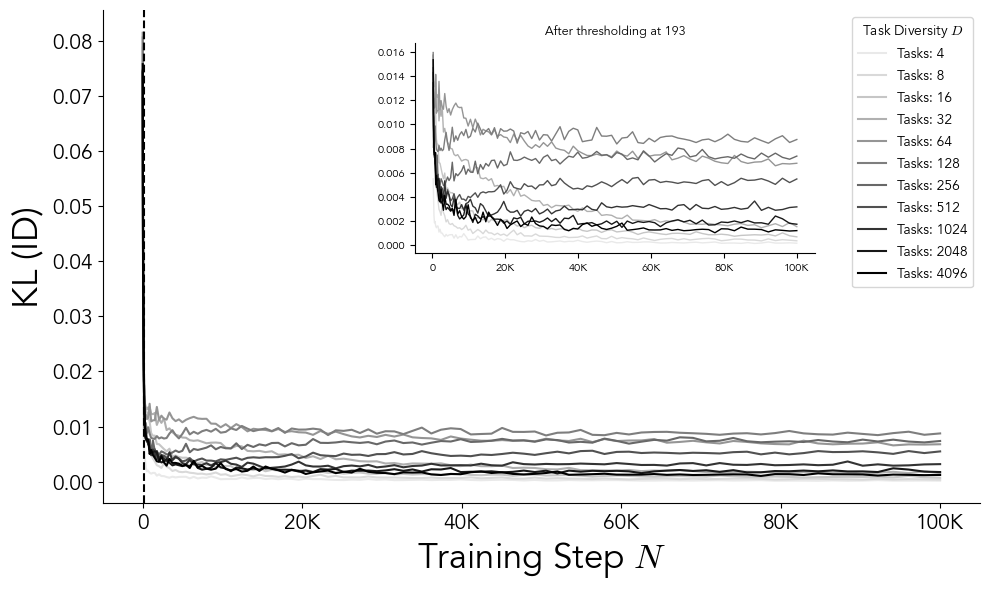

In [7]:
fig, ax = fig_gen.generate_interpolation_threshold_plot(
    config={"fixed_values": fixed_values}, show=True, save=SAVE_FIGS
)

## Showing Transience and task diversity threshold

### Transience


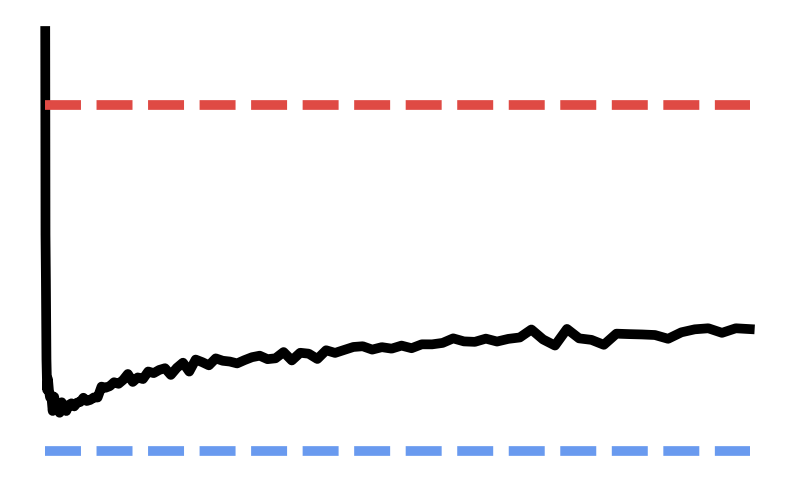

In [62]:
fixed_values_transience = fixed_values.copy()
fixed_values_transience["num_tasks"] = 256
fig_gen.generate_transience_plot(
    config={
        "fixed_values": fixed_values_transience,
        "mode": "eval",
        "x_scale": "linear",
        "main": True,
    },
    show=True,
    save=SAVE_FIGS,
)

### Task diversity threshold

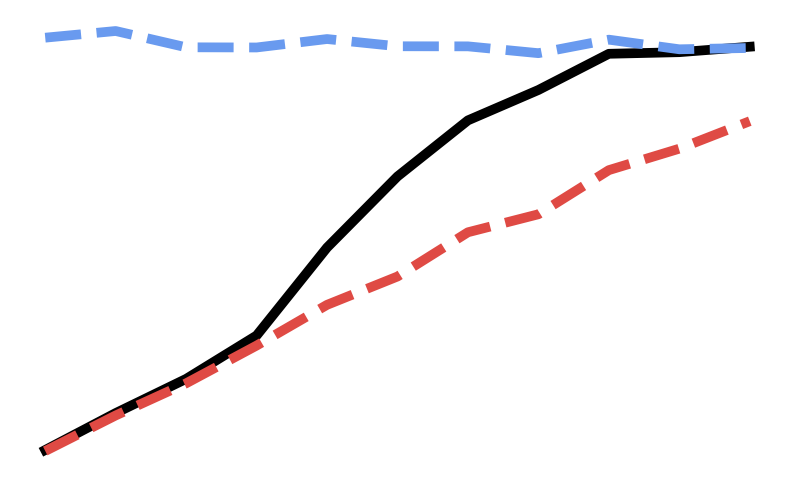

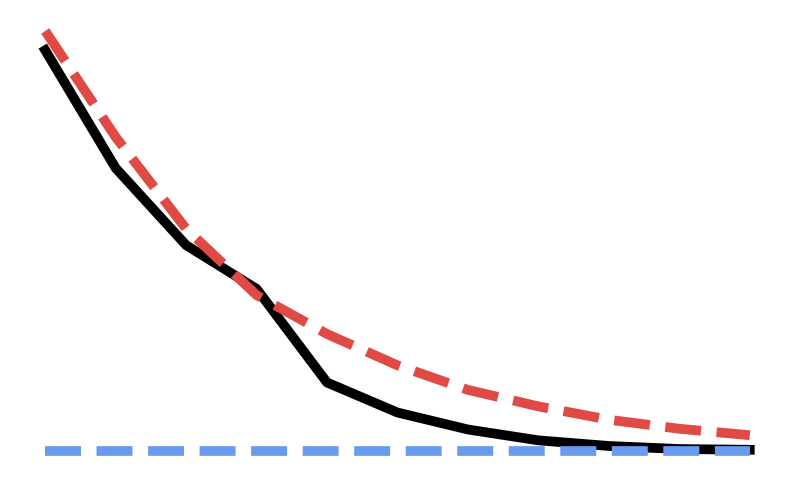

In [63]:
fixed_values_task_diversity = fixed_values.copy()
fixed_values_task_diversity["checkpoint"] = transformer_df["checkpoint"].unique()[-1]
fig_gen.generate_task_diversity_threshold_plot(
    config={
        "fixed_values": fixed_values_task_diversity,
        "main": True,
    },
    show=True,
    save=SAVE_FIGS,
)

## Relative distance phase diagram

Bbox(x0=0.12355555555555559, y0=0.15546296296296302, x1=0.8588659793814433, y1=0.975)


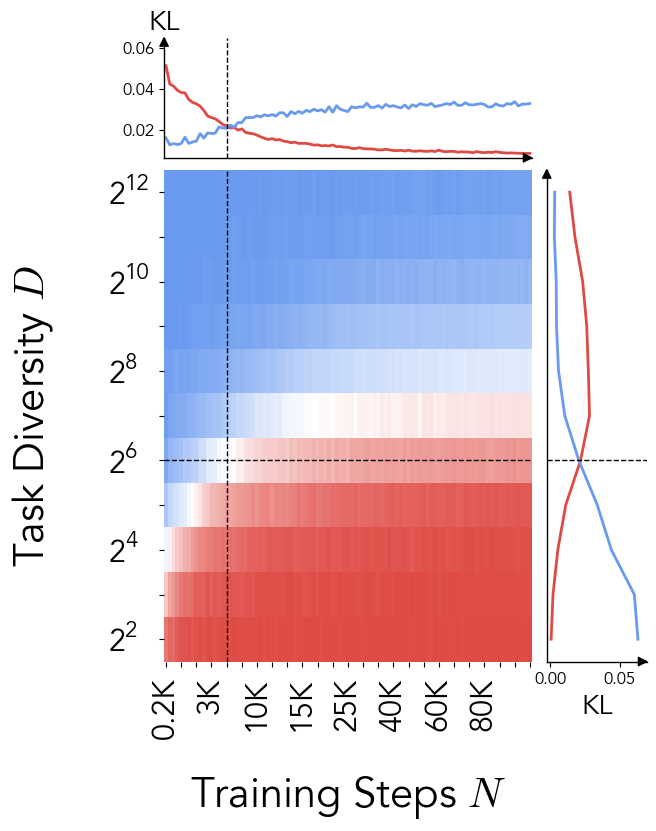

In [10]:
fig_gen.generate_relative_distance_plot(
    config={
        "fixed_values": fixed_values,
        "x_annotated": 16,
        "y_annotated": 4,
        "mode": "train",
    },
    show=True,
    save=SAVE_FIGS,
)

## Hierarchical Bayesian Model Framework


### Predicting using Bayesian Model 

/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2688: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2688: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2688: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars


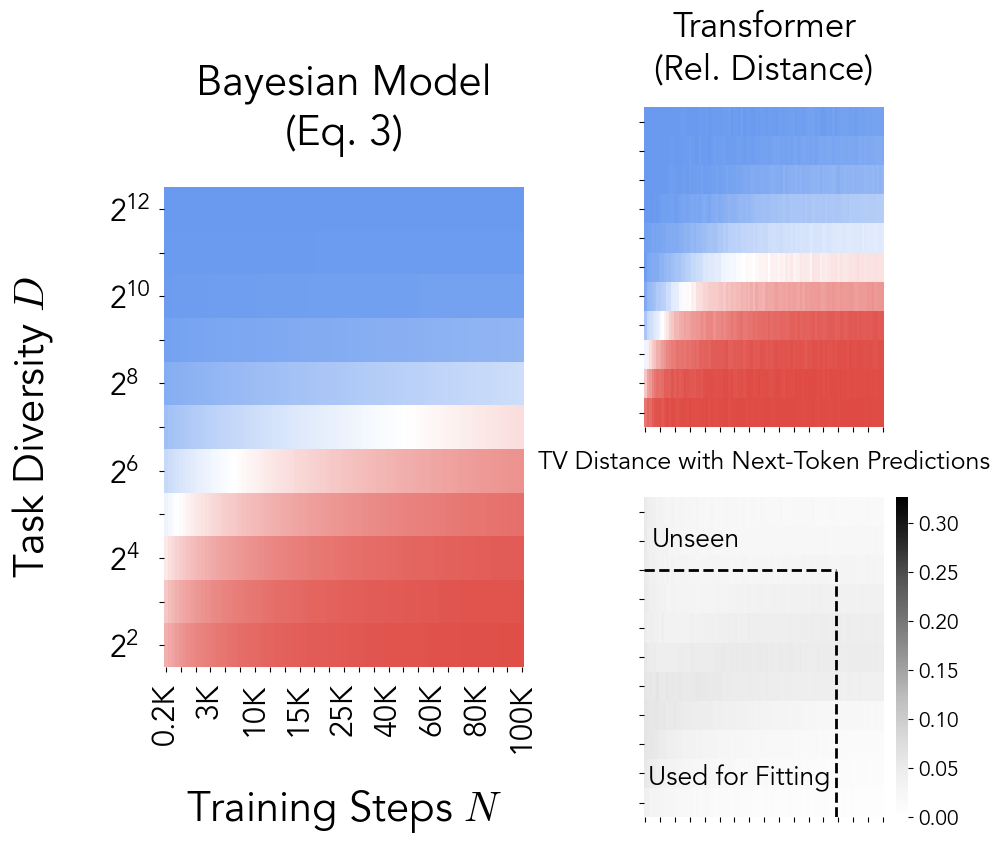

In [11]:
fig_gen.generate_prediction_comparison_plot(
    config={"fixed_values": fixed_values, "comparison_col": "relative_distance_train"},
    show=True,
    save=SAVE_FIGS,
)

### Intuitions from model

#### Log prior odds, log bayes factor, and log posterior odds

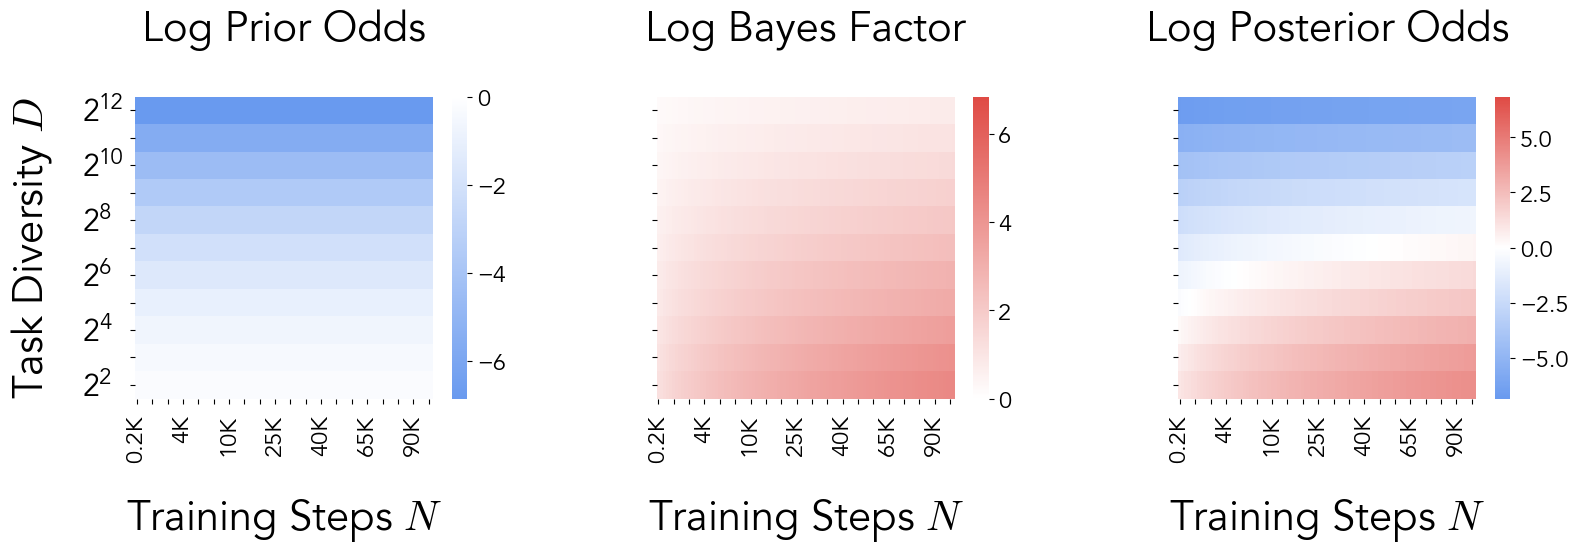

In [12]:
fig_gen.generate_posterior_odds_plot(
    config={"fixed_values": fixed_values}, show=True, save=SAVE_FIGS
)

#### Probabilities of each algorithm across training time

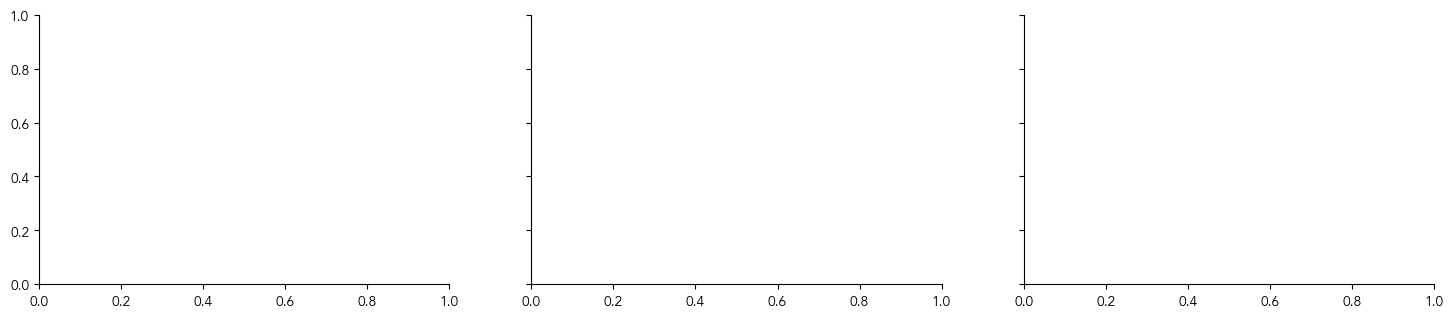

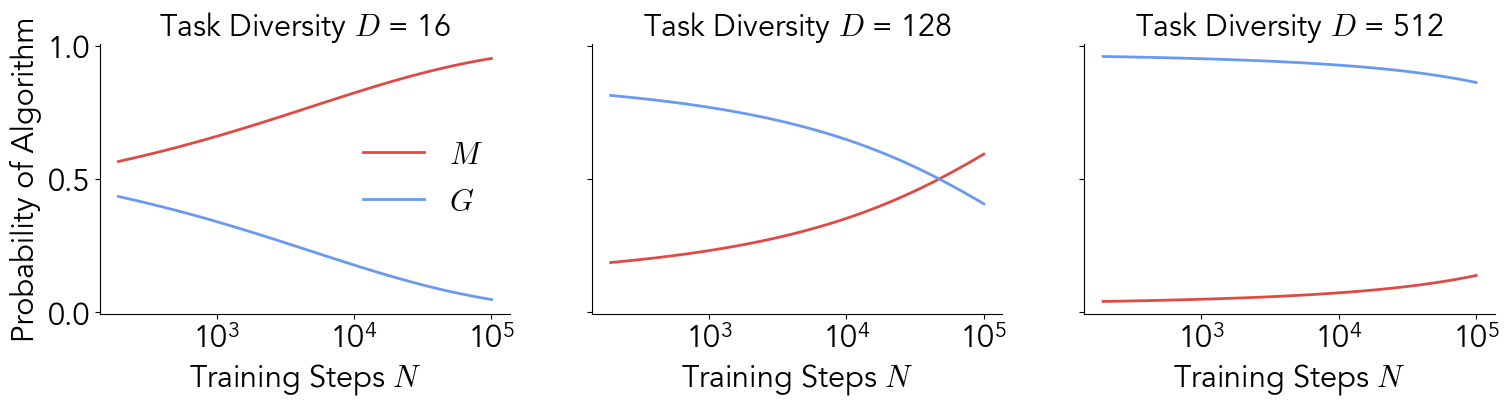

In [13]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 3.5), sharey=True)

# List of task diversity values to plot
task_diversity_values = [16, 128, 512]

fig_gen.generate_algorithm_probabilities_plot(
    config={
        "fixed_values": fixed_values,
        "task_diversity_values": task_diversity_values,
    },
    show=True,
    save=SAVE_FIGS,
)

### Predictions from framework

#### Sublinear evidence accumulation

Using alpha = 0.777805288597849, plotting against N^(1-0.777805288597849) = N^0.22219471140215097


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:1970: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


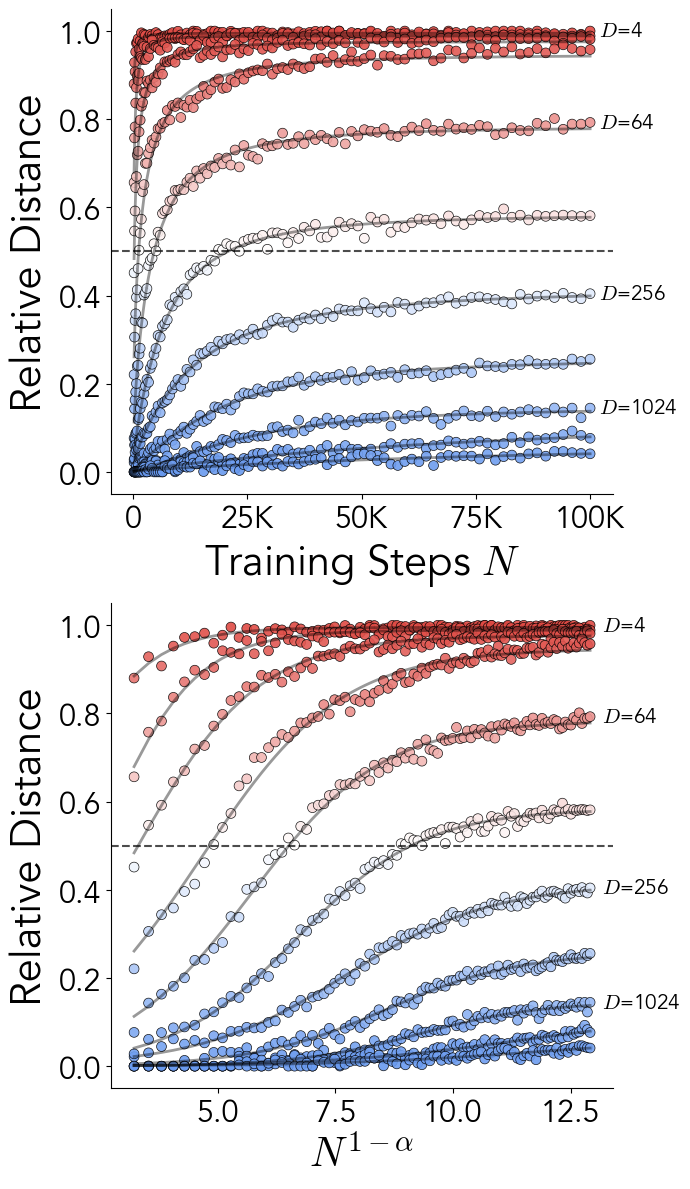

In [24]:
fig_gen.generate_sublinear_evidence_accumulation_plot(
    config={
        "fixed_values": fixed_values,
        "compare_with_predicted": False,
        "tasks_to_label": [4, 64, 256, 1024],
    },
    show=True,
    save=SAVE_FIGS,
)

#### Vector field

X-axis limits: 47.50578414770273 to 103187.2776601684
Y-axis limits: 3.249009585424942 to 5042.76751706078
Bbox(x0=0.1753230283610026, y0=0.17351851851851852, x1=0.9673275996315245, y1=0.975)


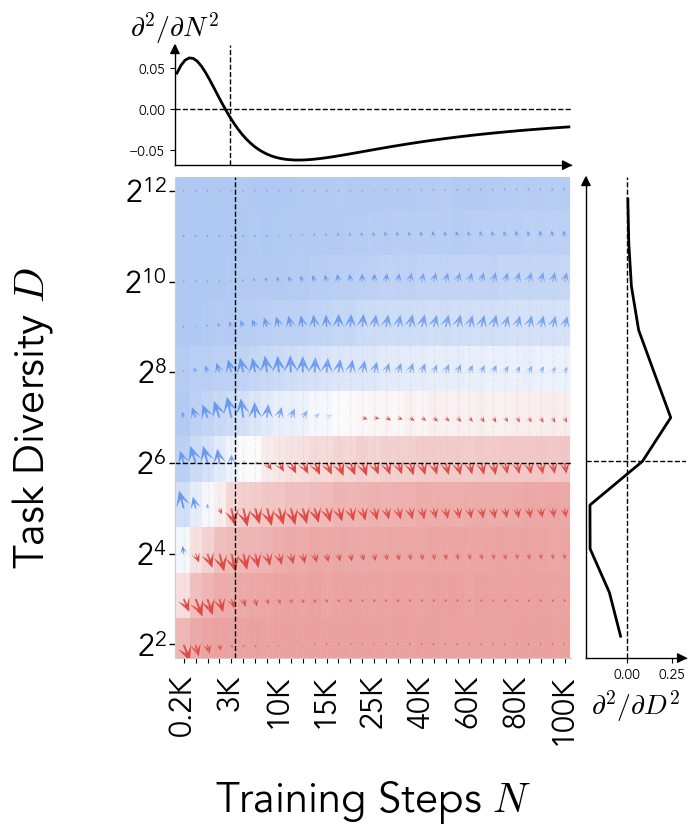

In [27]:
fig_gen.generate_vector_field_plot(
    config={"fixed_values": fixed_values, "fixed_x_index": 13, "fixed_y_index": 4},
    show=True,
    save=SAVE_FIGS,
)

## Appendix plots

### Task Diversity Threshold

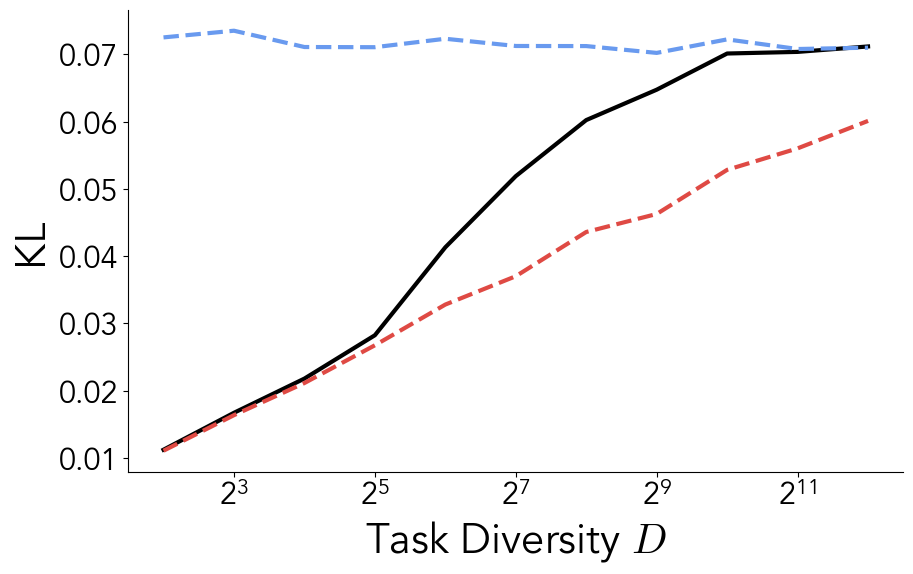

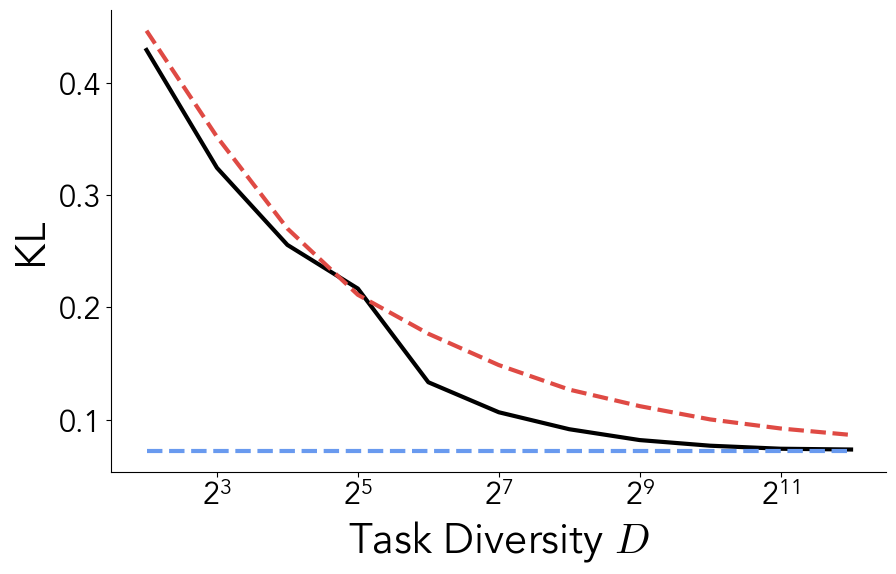

In [55]:
fixed_values_task_diversity = fixed_values.copy()
fixed_values_task_diversity["checkpoint"] = transformer_df["checkpoint"].unique()[-1]
fig_gen.generate_task_diversity_threshold_plot(
    config={"fixed_values": fixed_values_task_diversity, "main": False},
    show=True,
    save=SAVE_FIGS,
)

## Transience

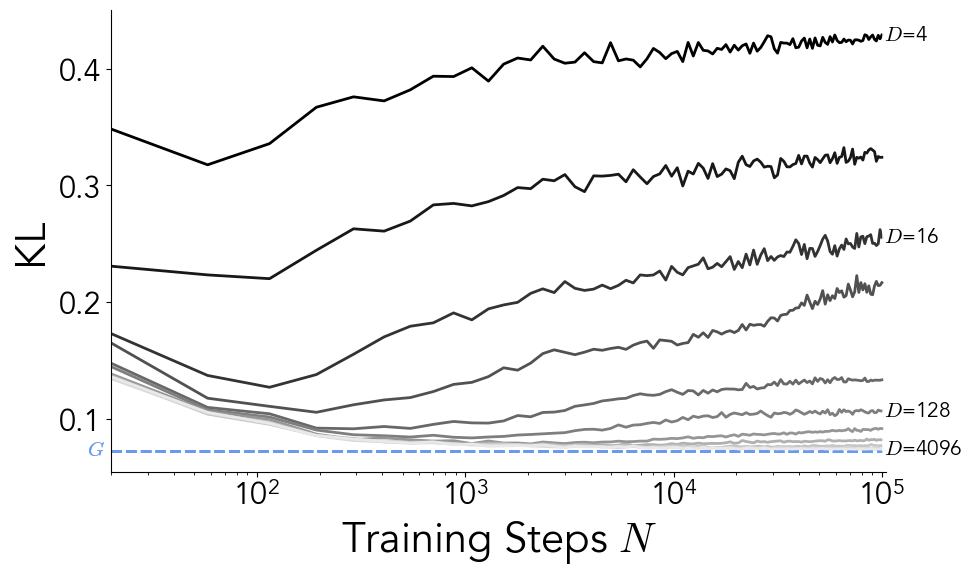

In [36]:
fig_gen.generate_transience_plot(
    config={
        "fixed_values": fixed_values_transience,
        "mode": "eval",
        "x_scale": "log",
        "main": False,
    },
    show=True,
    save=SAVE_FIGS,
)

## Relative and Absolute Distance side by side

/sailhome/wurgaft/normative-icl/src/code/make_figs.py:2189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.07, 0.05, 0.9, 0.98])


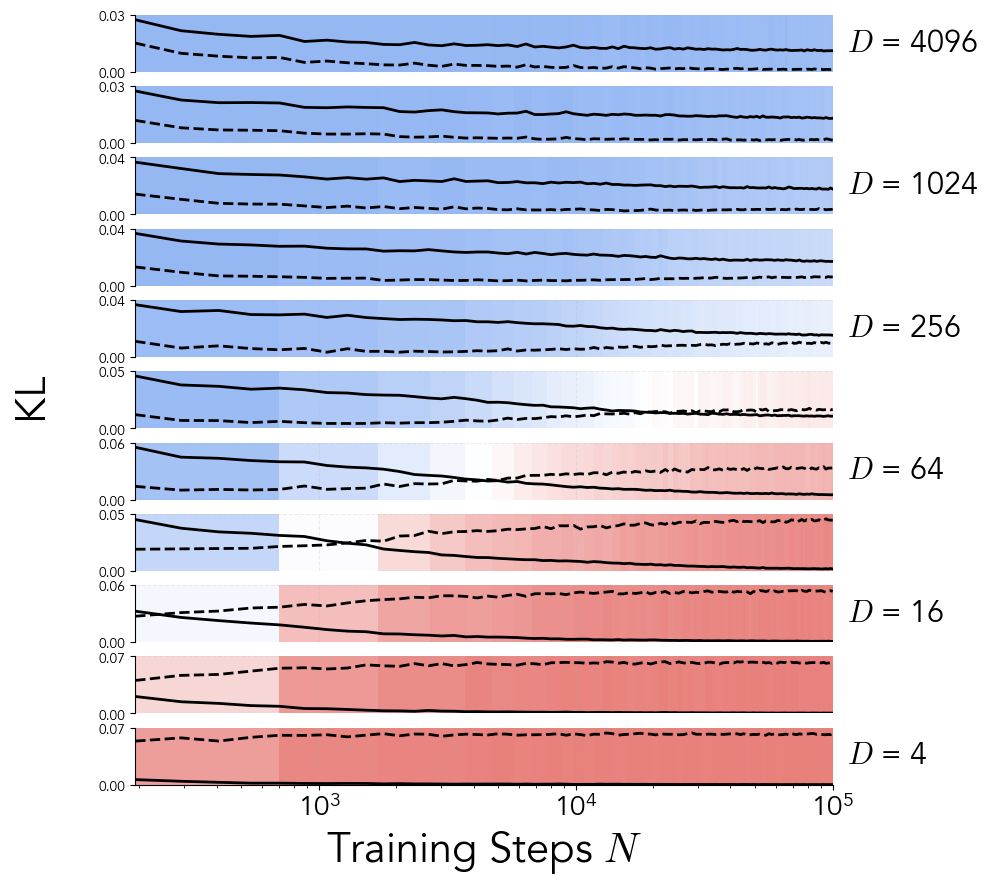

In [60]:
fig_gen.generate_relative_and_absolute_distance_plot(
    config={
        "fixed_values": fixed_values,
        "mode": "train",
        "xscale": "log",
    },
    show=True,
    save=SAVE_FIGS,
)